## ANA630 - Advanced Analytic Applications
### Dave Terando
### Project: Model Analysis with KMeans cluster as a Feature

In [2]:
# Core
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Data & ML
from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline 
from sklearn. impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, 
                             confusion_matrix, classification_report)
from sklearn.dummy import DummyClassifier

# Models
from sklearn. linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC 
from sklearn.naive_bayes import ComplementNB

# Interpretation
from sklearn.inspection import permutation_importance 
import warnings
warnings.filterwarnings("ignore")

pd. set_option("display.max_columns", None)
print(" Imports complete. Random state set to", RANDOM_STATE)

 Imports complete. Random state set to 42


In [3]:
#load fourth_down_df
fourth_down_df = pd.read_csv('fourth_down_dataframe.csv')

fourth_down_df.shape

(3932, 14)

In [4]:
# Select relevant features for clustering/classification
features = ['yardline_100', 'ydstogo', 'score_differential', 'game_seconds_remaining']

In [5]:
# Create X with features and series_success
X = fourth_down_df[features + ['series_success']].fillna(0)

In [6]:
# Keep unscaled data for summary
X_unscaled = fourth_down_df[features + ['series_success']].fillna(0)

In [7]:
X_unscaled.head()

,yardline_100,ydstogo,score_differential,game_seconds_remaining,series_success
0,1.0,1.0,3.0,2557.0,0.0
1,16.0,5.0,-4.0,37.0,0.0
2,34.0,7.0,0.0,3242.0,0.0
3,10.0,1.0,-17.0,900.0,1.0
4,69.0,4.0,-7.0,3077.0,0.0


In [8]:
X = fourth_down_df[features].fillna(0) 
y = fourth_down_df['series_success']  # Binary target (1=success, 0=failure)

print ("Shape:", X. shape)
print("Target distribution (0=no, 1=yes):")
print (y.value_counts())
display(X.head())

Shape: (3932, 4)
Target distribution (0=no, 1=yes):
1.0    2118
0.0    1814
Name: series_success, dtype: int64


,yardline_100,ydstogo,score_differential,game_seconds_remaining
0,1.0,1.0,3.0,2557.0
1,16.0,5.0,-4.0,37.0
2,34.0,7.0,0.0,3242.0
3,10.0,1.0,-17.0,900.0
4,69.0,4.0,-7.0,3077.0


In [9]:
# Scale features
scaler = StandardScaler()
X[features] = scaler.fit_transform(X[features])

print ("Shape:", X. shape)
print("Target distribution (0=no, 1=yes):")
print (y.value_counts())
display(X.head())

Shape: (3932, 4)
Target distribution (0=no, 1=yes):
1.0    2118
0.0    1814
Name: series_success, dtype: int64


,yardline_100,ydstogo,score_differential,game_seconds_remaining
0,-1.677632,-0.671206,0.776407,1.211638
1,-0.988343,0.219131,0.168429,-1.146242
2,-0.161196,0.664300,0.515845,1.852569
3,-1.264059,-0.671206,-0.960674,-0.338762
4,1.447145,-0.003453,-0.092133,1.698184


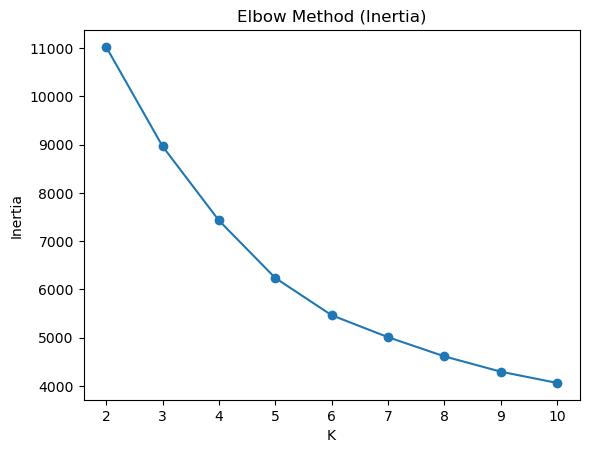

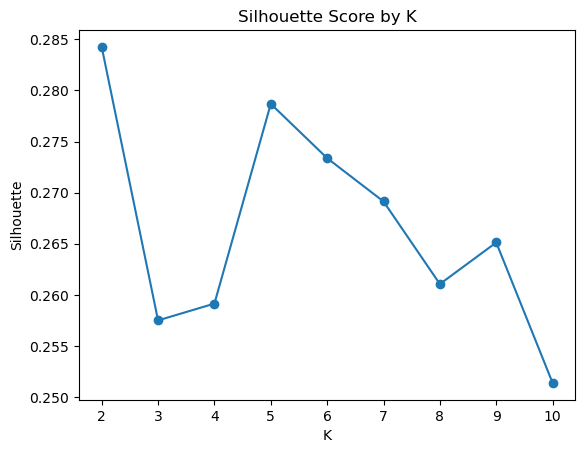

In [12]:
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

Ks = range (2, 11)
inertias = []
silhouettes = []
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_k = km.fit_predict(X)
    inertias.append(km.inertia_)
    silhouettes.append (silhouette_score(X, labels_k))
plt. figure()
plt.plot(list(Ks), inertias, marker='o')
plt.title( 'Elbow Method (Inertia)') 
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()
plt. figure()
plt.plot(list(Ks), silhouettes, marker='o')
plt. title( 'Silhouette Score by K') 
plt.xlabel('K')
plt.ylabel ('Silhouette')
plt. show()

### Run KMeans to add cluster feature

In [10]:
from sklearn.cluster import KMeans

# Clustering (group similar situations)
kmeans = KMeans(n_clusters=5, random_state=42)
X['cluster'] = kmeans.fit_predict(X[features])

print ("Shape:", X. shape)
print("Target distribution (0=no, 1=yes):")
print (y.value_counts())
display(X.head())

Shape: (3932, 5)
Target distribution (0=no, 1=yes):
1.0    2118
0.0    1814
Name: series_success, dtype: int64


,yardline_100,ydstogo,score_differential,game_seconds_remaining,cluster
0,-1.677632,-0.671206,0.776407,1.211638,1
1,-0.988343,0.219131,0.168429,-1.146242,3
2,-0.161196,0.664300,0.515845,1.852569,1
3,-1.264059,-0.671206,-0.960674,-0.338762,3
4,1.447145,-0.003453,-0.092133,1.698184,1


In [56]:
# Numerical summary
print("Number of plays per cluster:")
print(X['cluster'].value_counts().sort_index())
print("\nMean feature values by cluster:")
print(X.groupby('cluster')[features].mean())

Number of plays per cluster:
0     472
1    1235
2     912
3     747
4     566
Name: cluster, dtype: int64

Mean feature values by cluster:
         yardline_100   ydstogo  score_differential  game_seconds_remaining
cluster                                                                    
0            0.736729  2.195983           -0.524564               -0.854512
1           -0.145420 -0.426273            0.412394                1.250533
2            0.897628 -0.189916           -0.548689               -0.567614
3           -0.979546 -0.121450           -0.737551               -0.507045
4           -0.450633 -0.434858            1.395128               -0.432246


In [15]:
# Assign cluster labels to unscaled data
X_unscaled['cluster'] = X['cluster']

### Unscale values for better interpretability 

In [20]:
# Numerical summary with unscaled values
print("Number of plays per cluster:")
print(X['cluster'].value_counts().sort_index())
print("\nMean feature values by cluster (unscaled):")
print(X_unscaled.groupby('cluster')[features].mean().round(2))

Number of plays per cluster:
0     472
1    1235
2     912
3     747
4     566
Name: cluster, dtype: int64

Mean feature values by cluster (unscaled):
         yardline_100  ydstogo  score_differential  game_seconds_remaining
cluster                                                                   
0               53.54    13.88              -11.98                  348.79
1               34.34     2.10               -1.19                 2598.57
2               57.04     3.16              -12.26                  655.41
3               16.19     3.47              -14.43                  720.15
4               27.70     2.06               10.12                  800.09


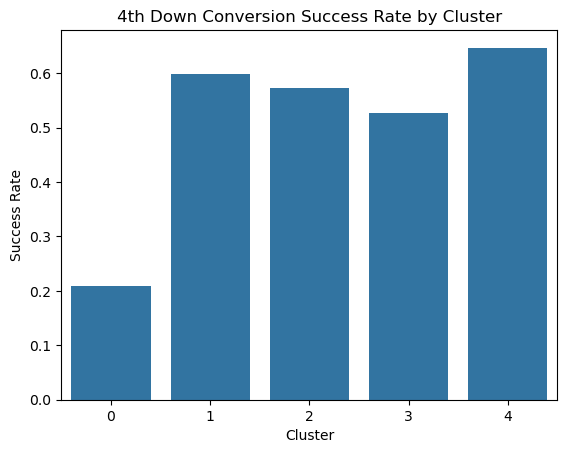

In [22]:
# Success rate bar plot
import seaborn as sns
success_rate = X_unscaled.groupby('cluster')['series_success'].mean()
sns.barplot(x=success_rate.index, y=success_rate.values)
plt.title('4th Down Conversion Success Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Success Rate')
plt.show()

#### Baseline Model: Dummy Classifier

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


baseline = DummyClassifier(strategy='most_frequent',random_state=RANDOM_STATE)
baseline.fit(X_train, y_train)
y_base = baseline.predict(X_test)

print("Baseline Accuracy:",accuracy_score (y_test, y_base))
print("\nBaseline Classification Report: \n", classification_report(y_test, y_base, target_names=['no', 'yes']))

Baseline Accuracy: 0.5387547649301143

Baseline Classification Report: 
               precision    recall  f1-score   support

          no       0.00      0.00      0.00       363
         yes       0.54      1.00      0.70       424

    accuracy                           0.54       787
   macro avg       0.27      0.50      0.35       787
weighted avg       0.29      0.54      0.38       787



In [12]:
# Reusable Evaluation Helpers

def fit_and_scores(model, X_train, y_train, X_test, y_test, name="model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_scores = None
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)
    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_scores) if y_scores is not None else np.nan
    }
    return metrics, y_pred, y_scores

def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    ax. imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(['No', 'Yes']); ax.set_yticklabels(['No','Yes'])
    for i in range (cm.shape[0]): 
        for j in range (cm.shape [1]) :
            ax.text(j, i, cm[i, j], ha="center", va="center")
    plt.show()

def plot_roc_pr_curves(y_true, y_scores, name="model"):
    if y_scores is None:
        print(f"{name}: No probability/decision scores available to plot ROC/PR.")
        return
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt. figure()
    plt. plot(fpr, tpr, label=name)
    plt. plot ([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate") 
    plt. title(f"ROC Curve: {name}"); plt.legend(); plt.show()
    prec, rec, _ = precision_recall_curve(y_true, y_scores)
    plt. figure()
    plt. plot(rec, prec, label=name)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve: {name}"); plt.legend(); plt.show()


In [13]:
# Establish a list for results from each model
fourth_down_results = []

In [33]:
# to clear results list if needed (every time a model is re-run it adds an iteration to the list)
fourth_down_results.clear()

#### Logistic Regression

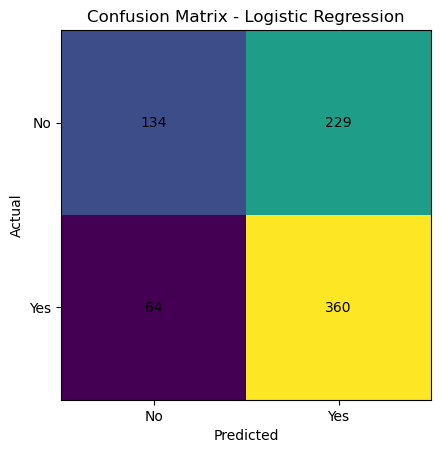

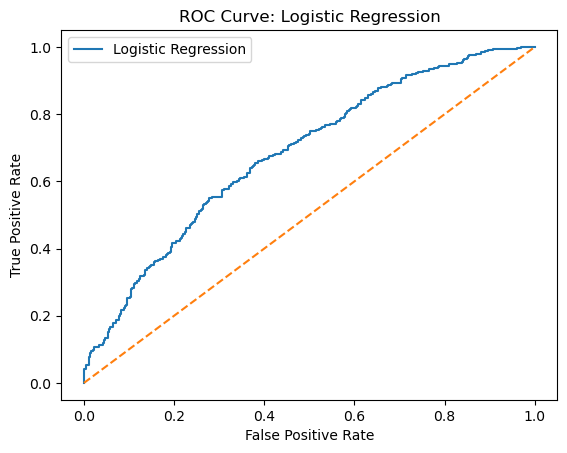

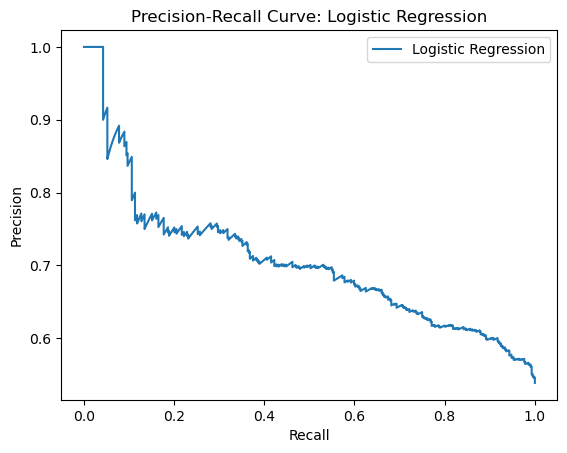

0.628


In [14]:
logreg = LogisticRegression(max_iter=1000, n_jobs=None, random_state=RANDOM_STATE)
m, y_pred, y_scores = fit_and_scores(logreg, X_train, y_train, X_test, y_test, "Logistic Regression")
fourth_down_results.append(m)
plot_confusion(y_test, y_pred, "Confusion Matrix - Logistic Regression") 
plot_roc_pr_curves(y_test, y_scores, "Logistic Regression")
score=logreg.score(X_test, y_test)
print(f"{score:.3f}")

#### k-Nearest Neighbors (k-NN)

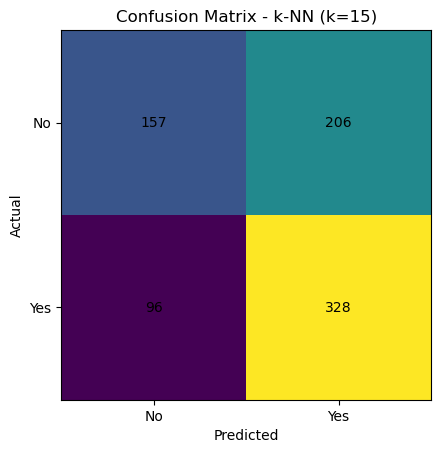

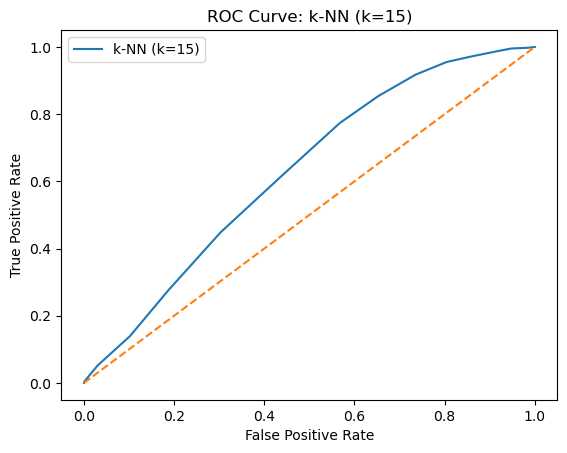

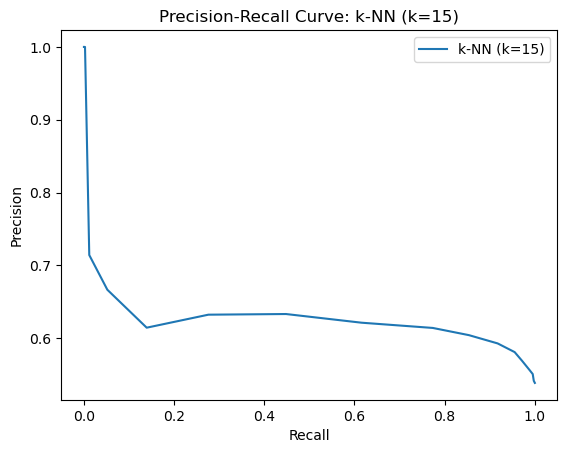

0.628


In [35]:
knn = KNeighborsClassifier(n_neighbors=15)
m, y_pred, y_scores = fit_and_scores(knn, X_train, y_train, X_test, y_test, "k-NN (k=15)")
fourth_down_results.append (m)
plot_confusion(y_test, y_pred, "Confusion Matrix - k-NN (k=15)") 
plot_roc_pr_curves(y_test, y_scores, "k-NN (k=15)")
knn.score(X_test, y_test)
print(f"{score:.3f}")

#### Decision Tree

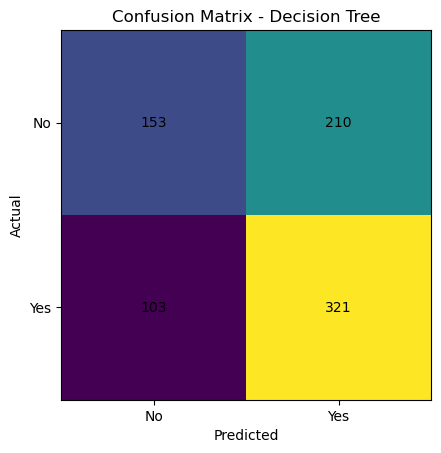

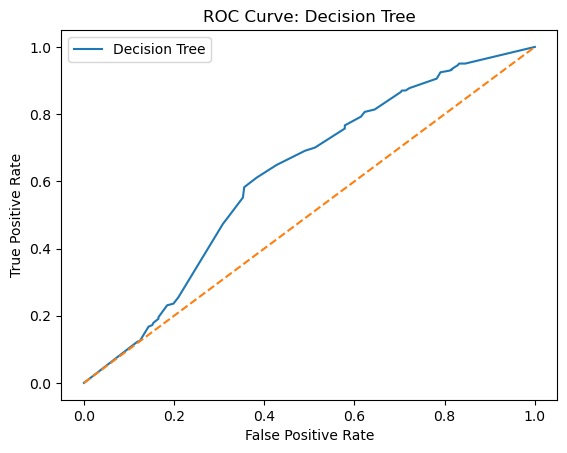

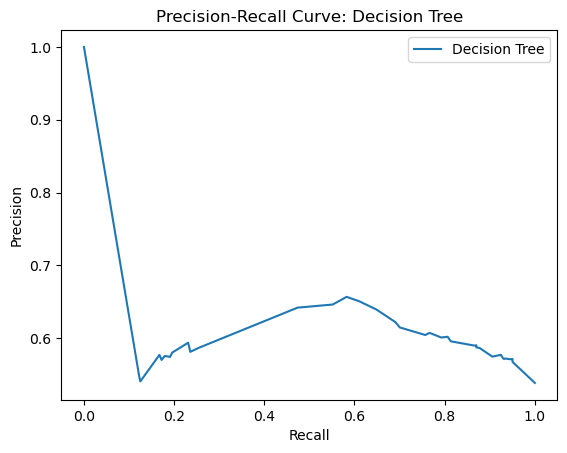

0.628


In [36]:
tree = DecisionTreeClassifier (max_depth=10, random_state=RANDOM_STATE)
m, y_pred, y_scores = fit_and_scores(tree, X_train, y_train, X_test, y_test, "Decision Tree (max_depth=12)")
fourth_down_results.append (m)
plot_confusion(y_test, y_pred, "Confusion Matrix - Decision Tree") 
plot_roc_pr_curves(y_test, y_scores, "Decision Tree")
tree.score(X_test, y_test)
print(f"{score:.3f}")

#### Random Forest

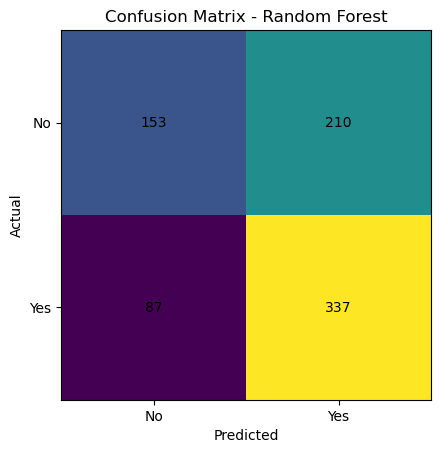

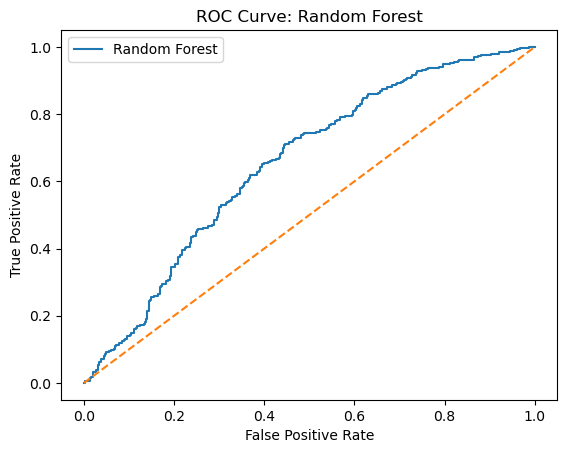

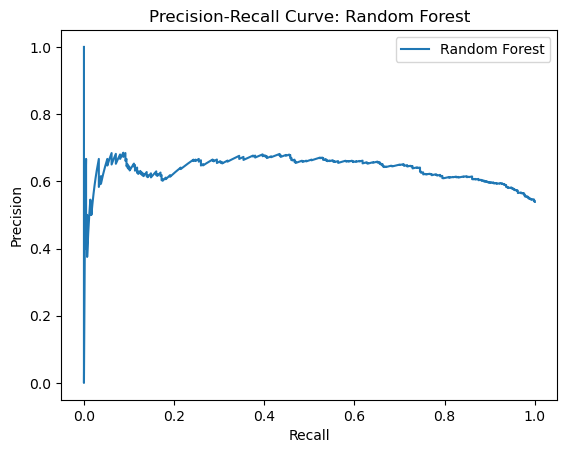

0.628


In [37]:
rf = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1, random_state=RANDOM_STATE)
m, y_pred, y_scores = fit_and_scores(rf, X_train, y_train, X_test, y_test, "Random Forest")
fourth_down_results.append (m)
plot_confusion (y_test, y_pred, "Confusion Matrix - Random Forest") 
plot_roc_pr_curves (y_test, y_scores, "Random Forest")
rf.score(X_test, y_test)
print(f"{score:.3f}")

#### Support Vector Machine (RBF)

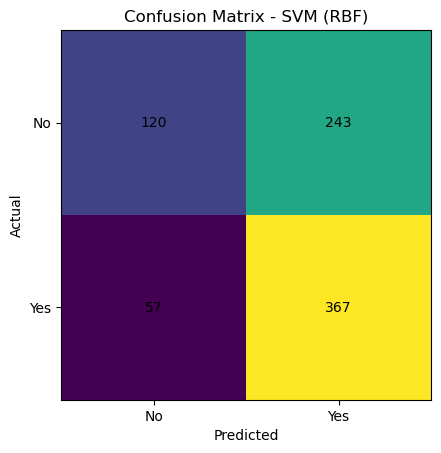

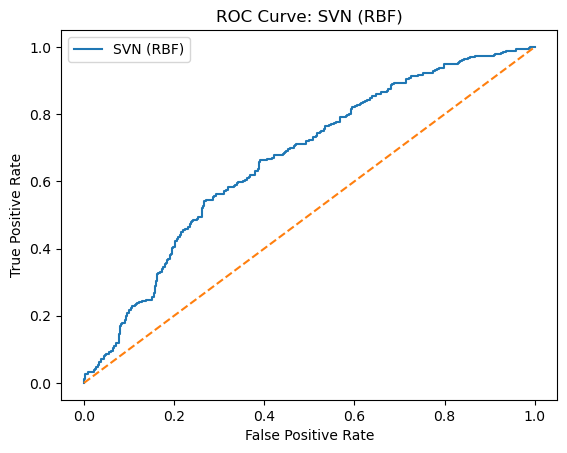

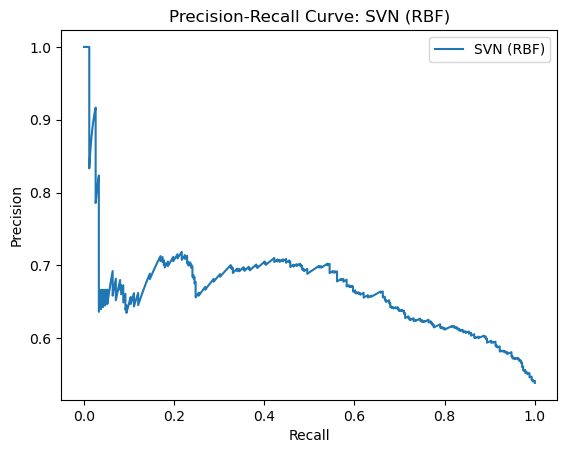

0.628


In [38]:
svm_rbf = SVC(kernel='rbf', probability=False, cache_size=2000, random_state=RANDOM_STATE)
m, y_pred, y_scores = fit_and_scores(svm_rbf, X_train, y_train, X_test, y_test, "SVM (RBF)")
fourth_down_results.append (m)
plot_confusion(y_test, y_pred, "Confusion Matrix - SVM (RBF)") 
plot_roc_pr_curves(y_test, y_scores, "SVN (RBF)")
svm_rbf.score(X_test, y_test)
print(f"{score:.3f}")

#### Gradient Boosting

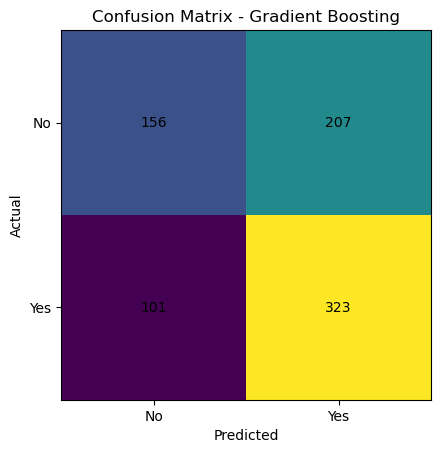

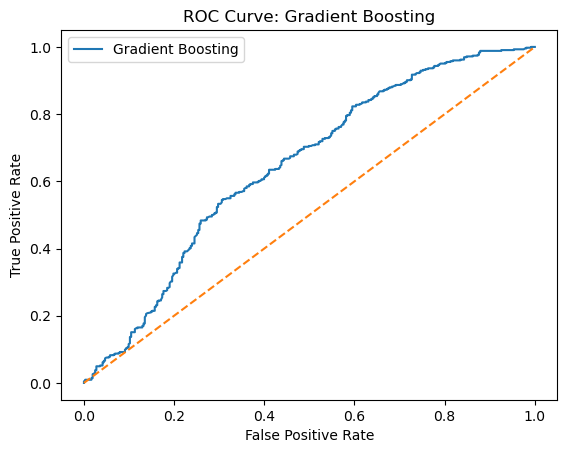

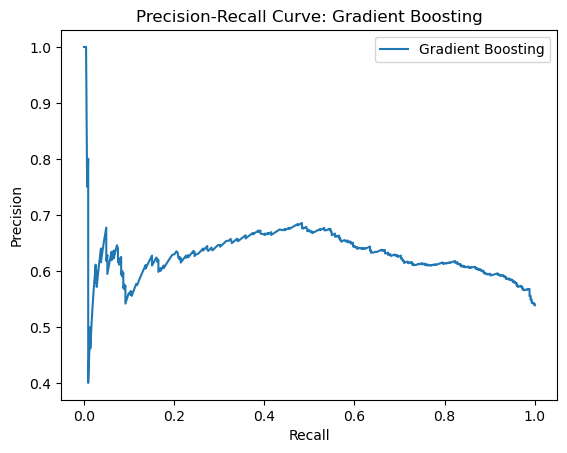

0.628


In [39]:
grbt = GradientBoostingClassifier(random_state=RANDOM_STATE)
m, y_pred, y_scores = fit_and_scores(grbt, X_train, y_train, X_test, y_test, "Gradient Boosting")
fourth_down_results.append (m)
plot_confusion(y_test, y_pred, "Confusion Matrix - Gradient Boosting") 
plot_roc_pr_curves(y_test, y_scores, "Gradient Boosting")
grbt.score(X_test, y_test)
print(f"{score:.3f}")

#### Model Evaluation Summary

In [40]:
# Display results list
results_df = pd.DataFrame(fourth_down_results).sort_values(by=['f1', 'roc_auc'], ascending=False)
cols_to_highlight = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
styled = results_df.style.highlight_max(subset=cols_to_highlight, axis=0, color='lightgreen')
display(styled)

,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.627700,0.611205,0.849057,0.710760,0.682215
4,SVM (RBF),0.618806,0.601639,0.865566,0.709865,0.666166
3,Random Forest,0.622618,0.616088,0.794811,0.694130,0.653458
1,k-NN (k=15),0.616264,0.614232,0.773585,0.684760,0.628151
5,Gradient Boosting,0.608640,0.609434,0.761792,0.677149,0.644238
2,Decision Tree (max_depth=12),0.602287,0.604520,0.757075,0.672251,0.616628


### Cross validation scores for Logistic Regression model

In [43]:
# run cross validation for logreg model (with K-means clusters)
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X, y, cv=5) # cv=5 for 5-fold cross-validation
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.2f}")
print(f"Standard deviation of accuracy: {np.std(scores):.2f}")


Cross-validation scores: [0.61880559 0.62897078 0.61832061 0.66157761 0.63486005]
Mean accuracy: 0.63
Standard deviation of accuracy: 0.02


### Feature coefficients for Logistic Regression model

In [44]:
# Get coefficients and feature names
coefficients = logreg.coef_[0]  # For binary classification
feature_names = X.columns

In [45]:
# Creatw a DF for visualisation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
# Sort by coefficient magnitude for better visualization
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

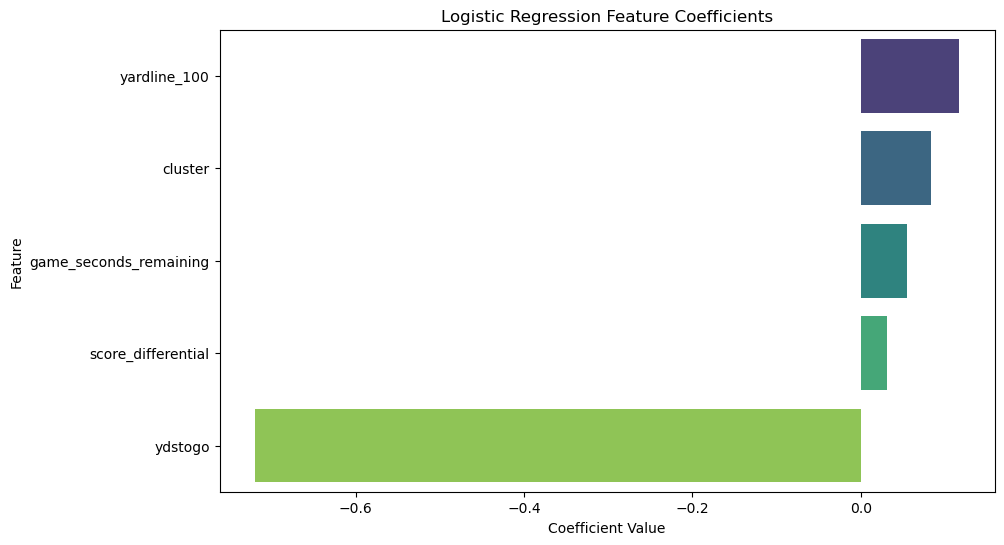

In [47]:
# visualise coeficient impact with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
plt.title('Logistic Regression Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

### Make predictions on unseen data

In [15]:
# Prepare unseen data
unseen_data = pd.DataFrame({
    'yardline_100': [45],          # Yards to opponent's endzone
    'ydstogo': [15],               # Yards to go
    'score_differential': [-7],   # Trailing by 7
    'game_seconds_remaining': [120]  # 2 minutes left
})

In [16]:
# Transform unseen data
unseen_data_scaled = scaler.transform(unseen_data[features])

# Assign cluster to unseen data
unseen_data['cluster'] = kmeans.predict(unseen_data[features])

In [17]:
unseen_data.head()

,yardline_100,ydstogo,score_differential,game_seconds_remaining,cluster
0,45,15,-7,120,1


In [18]:
# Make predictions
# Class prediction (0 = failure, 1 = success)
y_pred = logreg.predict(unseen_data)
# Probability prediction (probability of success)
y_pred_proba = logreg.predict_proba(unseen_data)[:, 1]  # Probability of class 1 (success)

In [19]:
# Output recommendation
threshold = 0.5  # Adjustable based on risk tolerance
for i, (pred, proba) in enumerate(zip(y_pred, y_pred_proba)):
    recommendation = "Go for it" if proba > threshold else "Punt or kick"
    print(f"Game Scenario {i + 1}:")
    print(f"Input - Yardline: {unseen_data['yardline_100'].iloc[i]}, Yards to Go: {unseen_data['ydstogo'].iloc[i]}, "
          f"Score Diff: {unseen_data['score_differential'].iloc[i]}, Time Left: {unseen_data['game_seconds_remaining'].iloc[i]}s")
    print(f"Predicted Success Probability: {proba:.3f}")
    print(f"Recommendation: {recommendation}\n")

Game Scenario 1:
Input - Yardline: 45, Yards to Go: 15, Score Diff: -7, Time Left: 120s
Predicted Success Probability: 0.696
Recommendation: Go for it



### Prepare code for Streamlit App

In [20]:
import joblib

# Save the following to directory where the app.py file was saved

joblib.dump(logreg, 'logreg_model.joblib')  # Save the Logistic Regression model
joblib.dump(scaler, 'scaler.joblib')        # Save the StandardScaler
joblib.dump(kmeans, 'kmeans.joblib')        # Save the K-Means model

# Save the feature list for reference
features = ['yardline_100', 'ydstogo', 'score_differential', 'game_seconds_remaining', 'cluster']
joblib.dump(features, 'features.joblib')

['features.joblib']

In [19]:
import streamlit as st

# Add this code to app.py file

# Load the saved components
logreg_model = joblib.load('logreg_model.joblib')
scaler = joblib.load('scaler.joblib')
kmeans = joblib.load('kmeans.joblib')
features = joblib.load('features.joblib')  # ['yardline_100', 'ydstogo', 'score_differential', 'game_seconds_remaining', 'cluster']
main_features = features[:-1]  # ['yardline_100', 'ydstogo', 'score_differential', 'game_seconds_remaining']

# App title and description
st.title("NFL 4th Down Decision Tool")
st.write("Enter game conditions to predict 4th down conversion success and get a recommendation.")

# User inputs for the four main features
yardline_100 = st.number_input("Yards to Opponent's Endzone (yardline_100)", min_value=0.0, max_value=100.0, value=45.0)
ydstogo = st.number_input("Yards to Go (ydstogo)", min_value=0.0, max_value=50.0, value=3.0)
score_differential = st.number_input("Score Differential (positive if leading)", min_value=-50.0, max_value=50.0, value=-7.0)
game_seconds_remaining = st.number_input("Seconds Remaining in Game (game_seconds_remaining)", min_value=0.0, max_value=3600.0, value=120.0)

# Button to trigger prediction
if st.button("Predict Success Probability"):
    # Prepare unseen data as a DataFrame
    unseen_data = pd.DataFrame({
        'yardline_100': [yardline_100],
        'ydstogo': [ydstogo],
        'score_differential': [score_differential],
        'game_seconds_remaining': [game_seconds_remaining]
    })

    # Scale the four main features using the pre-fitted scaler
    unseen_data_scaled = scaler.transform(unseen_data[main_features])

    # Assign cluster using the loaded K-Means on scaled data (since K-Means was fit on scaled data)
    unseen_data['cluster'] = kmeans.predict(unseen_data_scaled)

    # Full input for model (four main + cluster)
    unseen_data_full = unseen_data[features]

    # Make prediction
    proba = logreg_model.predict_proba(unseen_data_full)[:, 1][0]  # Probability of success (class 1)

    # Recommendation based on threshold
    threshold = 0.5  # Adjustable threshold (e.g., 0.6 for conservative)
    recommendation = "Go for it" if proba > threshold else "Punt or kick"

    # Display results
    st.subheader("Prediction Results")
    st.write(f"**Predicted Success Probability:** {proba:.3f} (or {proba * 100:.1f}%)")
    st.write(f"**Recommendation:** {recommendation}")
    if proba > threshold:
        st.success("High chance of success – consider going for it!")
    else:
        st.warning("Low chance of success – safer to punt or kick.")

    # Optional: Show input details for debugging
    st.write("**Input Details:**", unseen_data_full.to_dict())

2025-09-19 13:18:36.401 
  command:

    streamlit run /opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-09-19 13:18:36.402 Session state does not function when running a script without `streamlit run`
